In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/playground-series-s4e12/sample_submission.csv
/kaggle/input/playground-series-s4e12/train.csv
/kaggle/input/playground-series-s4e12/test.csv


# 1) Data Cleaning

## configuring training and test data 

In [2]:
train_data = pd.read_csv('/kaggle/input/playground-series-s4e12/train.csv')
y = train_data['Premium Amount']
train_data = train_data.drop(['id', 'Premium Amount'], axis=1)

test_data = pd.read_csv('/kaggle/input/playground-series-s4e12/test.csv')
test_ids = test_data['id']
test_data = test_data.drop(['id'], axis=1)

# function to check for NaN values in a specified column
def checknan(colname):
    return train_data[train_data[colname].isna()]

# function to fillna with either mean, median, 0, or another column
def fillNaN(colnamelist, type, othercol=None, datasetlist=[train_data, test_data]):
    if type == 'mean':
        for dataset in datasetlist:
            for colname in colnamelist:
                dataset.fillna({colname: train_data[colname].mean()}, inplace=True) # Version14: adding test_data to the fillNaN function
    elif type == 'median':
        for dataset in datasetlist:
            for colname in colnamelist:
                dataset.fillna({colname: train_data[colname].median()}, inplace=True)
    elif type == 'mode':
        for dataset in datasetlist:
            for colname in colnamelist:
                dataset.fillna({colname: train_data[colname].mode()[0]}, inplace=True)
    elif type == 0:
        for dataset in datasetlist:
            for colname in colnamelist:
                dataset.fillna({colname: 0}, inplace=True)
    elif type == 'othercol':
        for dataset in datasetlist:
            for colname in colnamelist:
                dataset.fillna({colname: train_data[othercol]}, inplace=True)
    print(f'fillNaN [{type}] complete')

# nan_cols = train_data.columns[train_data.isna().any()]
# for col in nan_cols:
#     print(f'- {col}')

meanfillna = ['Age', 'Number of Dependents', 'Health Score']
medianfillna = ['Annual Income', 'Vehicle Age', 'Credit Score', 'Insurance Duration']
modefillna = ['Marital Status', 'Occupation', 'Previous Claims', 'Customer Feedback']

fillNaN(meanfillna, 'mean') # fillna for columns using mean
fillNaN(medianfillna, 'median') # fillna for columns using median
fillNaN(modefillna, 'mode') # fillna for columns using mode

# processing the values in the 'Policy Start Date', 'Gender', 'Customer Feedback', and 'Smoking Status' columns
# starting with 'Policy Start Date'
train_data['Policy Start Date'] = pd.to_datetime(train_data['Policy Start Date'])
train_data['start year'] = train_data['Policy Start Date'].dt.year
train_data['start month'] = train_data['Policy Start Date'].dt.month
train_data = train_data.drop(['Policy Start Date'], axis=1)

test_data['Policy Start Date'] = pd.to_datetime(test_data['Policy Start Date'])
test_data['start year'] = test_data['Policy Start Date'].dt.year
test_data['start month'] = test_data['Policy Start Date'].dt.month
test_data = test_data.drop(['Policy Start Date'], axis=1)

monthmap = {
    1: 'Jan',
    2: 'Feb',
    3: 'Mar',
    4: 'Apr',
    5: 'May',
    6: 'Jun',
    7: 'Jul',
    8: 'Aug',
    9: 'Sep',
    10: 'Oct',
    11: 'Nov',
    12: 'Dec'
}

train_data['start month'] = train_data['start month'].map(monthmap)
test_data['start month'] = test_data['start month'].map(monthmap)

# on to 'Gender'
gendermap = {'Male': 1, 'Female': 0}
train_data['Gender'] = train_data['Gender'].map(gendermap)
test_data['Gender'] = test_data['Gender'].map(gendermap)

# Customer Feedback
feedbackmap = {'Poor': 1, 'Average': 2, 'Good': 3}
train_data['Customer Feedback'] = train_data['Customer Feedback'].map(feedbackmap)
test_data['Customer Feedback'] = test_data['Customer Feedback'].map(feedbackmap)

# Smoking Status
smokingmap = {'Yes': 1, 'No': 0}
train_data['Smoking Status'] = train_data['Smoking Status'].map(smokingmap)
test_data['Smoking Status'] = test_data['Smoking Status'].map(smokingmap)
print(len(train_data))
print(len(test_data))

# prepping data to go into machine learning model
from sklearn.model_selection import train_test_split
train_data = pd.get_dummies(train_data)
test_data = pd.get_dummies(test_data)

# converting boolean values to int
bool_columns = train_data.select_dtypes(include=['bool']).columns
train_data[bool_columns] = train_data[bool_columns].astype(int)
test_data[bool_columns] = test_data[bool_columns].astype(int)

# splitting train_data into train and mock test data
X_train, X_mocktest, y_train, y_mocktest = train_test_split(train_data, y, test_size=0.2, random_state=0)
print(len(X_train))

print(pd.concat([train_data.nunique(), test_data.nunique()], axis=1))

fillNaN [mean] complete
fillNaN [median] complete
fillNaN [mode] complete
1200000
800000
960000
                                  0       1
Age                              48      48
Gender                            2       2
Annual Income                 88593   80716
Number of Dependents              6       6
Health Score                 532658  388703
Previous Claims                  10      10
Vehicle Age                      20      20
Credit Score                    550     550
Insurance Duration                9       9
Customer Feedback                 3       3
Smoking Status                    2       2
start year                        6       6
Marital Status_Divorced           2       2
Marital Status_Married            2       2
Marital Status_Single             2       2
Education Level_Bachelor's        2       2
Education Level_High School       2       2
Education Level_Master's          2       2
Education Level_PhD               2       2
Occupation_Employed     

# 2) Model Configuration

## 1. Linear Regressor

In [3]:
# from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_log_error as msle

# lrmodel = LinearRegression()
# lrmodel.fit(X_train, y_train)
# mockpreds = lrmodel.predict(X_mocktest)

def rmsle(actual_y, predicted_y):
    return np.sqrt(msle(actual_y, predicted_y))

# print(rmsle(y_mocktest, mockpreds))

# # # deleting objects after use to prevent ram overload
# # del mockpreds, X_train, X_mocktest, y_train, y_mocktest

## 2. DecisionTreeRegressor

In [4]:
# from sklearn.tree import DecisionTreeRegressor
# dtrmodel = DecisionTreeRegressor(random_state=0)
# dtrmodel.fit(X_train, y_train)
# mockpreds = dtrmodel.predict(X_mocktest)
# print(rmsle(y_mocktest, mockpreds))

# # # deleting objects after use to prevent ram overload
# # del mockpreds, X_train, X_mocktest, y_train, y_mocktest

## 3. RandomForestRegressor

In [5]:
# from sklearn.ensemble import RandomForestRegressor
# rfrmodel = RandomForestRegressor(random_state=0)
# rfrmodel.fit(X_train, y_train)
# mockpreds = rfrmodel.predict(X_mocktest)
# print(rmsle(y_mocktest, mockpreds))

## 3. Deep Neural Network with TensorFlow 

Epoch 1/100
9600/9600 ━━━━━━━━━━━━━━━━━━━━ 16s 2ms/step - loss: 2.9415 - val_loss: 1.1915
Epoch 2/100
9600/9600 ━━━━━━━━━━━━━━━━━━━━ 15s 2ms/step - loss: 1.1889 - val_loss: 1.1866
Epoch 3/100
9600/9600 ━━━━━━━━━━━━━━━━━━━━ 15s 2ms/step - loss: 1.1849 - val_loss: 1.1823
Epoch 4/100
9600/9600 ━━━━━━━━━━━━━━━━━━━━ 15s 2ms/step - loss: 1.1818 - val_loss: 1.1809
Epoch 5/100
9600/9600 ━━━━━━━━━━━━━━━━━━━━ 15s 2ms/step - loss: 1.1807 - val_loss: 1.1797
Epoch 6/100
9600/9600 ━━━━━━━━━━━━━━━━━━━━ 15s 2ms/step - loss: 1.1789 - val_loss: 1.1765
Epoch 7/100
9600/9600 ━━━━━━━━━━━━━━━━━━━━ 15s 2ms/step - loss: 1.1757 - val_loss: 1.1735
Epoch 8/100
9600/9600 ━━━━━━━━━━━━━━━━━━━━ 15s 2ms/step - loss: 1.1731 - val_loss: 1.1714
Epoch 9/100
9600/9600 ━━━━━━━━━━━━━━━━━━━━ 15s 2ms/step - loss: 1.1713 - val_loss: 1.1700
Epoch 10/100
9600/9600 ━━━━━━━━━━━━━━━━━━━━ 15s 2ms/step - loss: 1.1700 - val_loss: 1.1689
Epoch 11/100
9600/9600 ━━━━━━━━━━━━━━━━━━━━ 15s 2ms/step - loss: 1.1690 - val_loss: 1.1679
Epoch 12

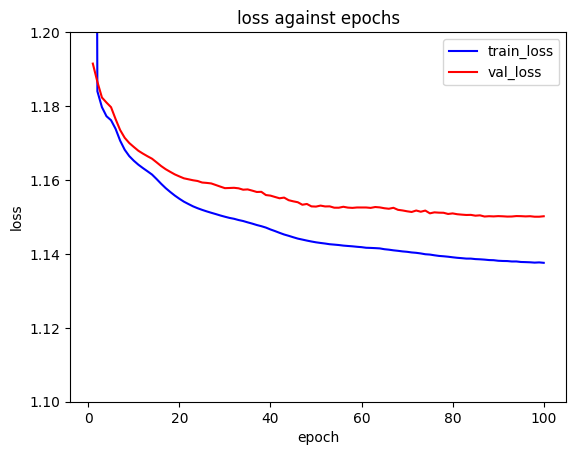

In [6]:
import tensorflow as tf
from tensorflow import keras
from keras.layers import Dense
import numpy as np
# from tensorflow.keras.initializers import HeNormal

# setting constant random_seed, similar to random_state in previous models
keras.utils.set_random_seed(0)

# Versmaking sequential api model
seqmodel = tf.keras.Sequential()
# start off small with 3 layers, including the input and output layers
seqmodel.add(tf.keras.layers.Input(shape=(47,)))
seqmodel.add(tf.keras.layers.Dense(64, activation='relu'))
seqmodel.add(tf.keras.layers.Dense(32, activation='relu'))
seqmodel.add(tf.keras.layers.Dense(1))
seqmodel.compile(
    optimizer='adam',
    loss='msle'
    # metrics=['mae', 'RootMeanSquaredError']
)

# converting dataframes to arrays
X_train = X_train.to_numpy()
X_mocktest = X_mocktest.to_numpy()
y_train = y_train.to_numpy()
y_mocktest = y_mocktest.to_numpy()

# Version 28: minmax scaling data
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_mocktest = scaler.fit_transform(X_mocktest)

# training the model
batchsize = 100
epochnumber = 100
history = seqmodel.fit(X_train, y_train, epochs=epochnumber, batch_size=batchsize, validation_data=(X_mocktest, y_mocktest))
# seqmodel.evaluate(X_mocktest, y_mocktest, batch_size=batchsize)

# plotting RMSLE against epoch number
import matplotlib.pyplot as plt

train_RMSLE = history.history['loss'] # accessing list of training losses
val_RMSLE = history.history['val_loss'] # accessing list of validation losses
# making list of epochs for x-axis of graph
epochlist = []
for e in range(1, epochnumber+1):
    epochlist.append(e)
# plotting graph
plt.plot(epochlist, train_RMSLE, color='blue', label='train_loss')
plt.plot(epochlist, val_RMSLE, color='red', label='val_loss')
plt.ylim(1.1, 1.2)
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('loss against epochs')
plt.legend()
plt.show()

# Submission (for sequential nn)

In [7]:
# converting training df to np arrays
train_data = scaler.fit_transform(train_data)
y = y.to_numpy()

seqmodel.fit(train_data, y, epochs=epochnumber, batch_size=batchsize)

# prepping test_data for the model
test_data = pd.get_dummies(test_data)
test_data = scaler.fit_transform(test_data)

preds = seqmodel.predict(test_data, batch_size=batchsize)

# creating submission Dataframe
preds = preds.flatten()
output = pd.DataFrame({'id': test_ids, 'Premium Amount': preds})
print(output)
output.to_csv('submission.csv', index=False)
print('success yahuu')

Epoch 1/100
12000/12000 ━━━━━━━━━━━━━━━━━━━━ 16s 1ms/step - loss: 1.1400
Epoch 2/100
12000/12000 ━━━━━━━━━━━━━━━━━━━━ 16s 1ms/step - loss: 1.1398
Epoch 3/100
12000/12000 ━━━━━━━━━━━━━━━━━━━━ 16s 1ms/step - loss: 1.1396
Epoch 4/100
12000/12000 ━━━━━━━━━━━━━━━━━━━━ 16s 1ms/step - loss: 1.1394
Epoch 5/100
12000/12000 ━━━━━━━━━━━━━━━━━━━━ 16s 1ms/step - loss: 1.1395
Epoch 6/100
12000/12000 ━━━━━━━━━━━━━━━━━━━━ 16s 1ms/step - loss: 1.1394
Epoch 7/100
12000/12000 ━━━━━━━━━━━━━━━━━━━━ 15s 1ms/step - loss: 1.1392
Epoch 8/100
12000/12000 ━━━━━━━━━━━━━━━━━━━━ 16s 1ms/step - loss: 1.1392
Epoch 9/100
12000/12000 ━━━━━━━━━━━━━━━━━━━━ 16s 1ms/step - loss: 1.1391
Epoch 10/100
12000/12000 ━━━━━━━━━━━━━━━━━━━━ 16s 1ms/step - loss: 1.1390
Epoch 11/100
12000/12000 ━━━━━━━━━━━━━━━━━━━━ 16s 1ms/step - loss: 1.1389
Epoch 12/100
12000/12000 ━━━━━━━━━━━━━━━━━━━━ 15s 1ms/step - loss: 1.1389
Epoch 13/100
12000/12000 ━━━━━━━━━━━━━━━━━━━━ 16s 1ms/step - loss: 1.1389
Epoch 14/100
12000/12000 ━━━━━━━━━━━━━━━━━━━━ 1